In [1]:
import nasdaqdatalink
import os
import json
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas_market_calendars as mcal
from datetime import datetime
import requests
from refresh_functions import *
pd.options.display.float_format = '{:.6f}'.format

#modelling packages ------
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.target import FeatureCorrelation
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC

import shap

#store my API key
with open('C:/Users/meich/.nasdaq/data_link_apikey.json') as f:
    data=json.load(f)
    key=data['api_key']
quandl.ApiConfig.api_key = key

# Data Refresh & Load
-----
Next step: schedule this code block daily in the cloud (which means having cloud storage for the data also)

In [2]:
%%time

#PRICES 
sharadarSEP()
sep = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/SHARADAR_SEP.csv')

#TICKERS + CATEGORIES
tickers = sharadarTICKERS()

#DAILY FUNDAMENTALS
sharadarDAILY()
daily = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/SHARADAR_DAILY.csv')
daily['marketcap_max'] = daily.groupby('ticker')['marketcap'].transform(max)
daily = daily[daily['marketcap_max']>=500]
daily['marketcap_total'] = daily.groupby('date')['marketcap'].transform(sum)

#SHORT INTEREST ACTIVITY (FINRA)
finraSHORTS()
si = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/FINRA_SI.csv')

#RETAIL TRADER ACTIVITY
nasdaqRTAT()
rtat = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/NDAQ_RTAT.csv')

Data up to date
2023-01-13
'sharadarSEP' 0.07 mins
'sharadarTICKERS' 0.49 mins
Data up to date
2023-01-13
'sharadarDAILY' 0.11 mins
Data up to date:
2023-01-13
'finraSHORTS' 0.07 mins
Data up to date:
2023-01-13
'nasdaqRTAT' 0.08 mins
Wall time: 1min 5s


### Create foundational dataset (shar)

In [3]:
combined = daily.merge(tickers,left_on='ticker',right_on='ticker',how='left')
combined = combined.merge(sep,left_on=['date','ticker'],right_on=['date','ticker'],how='left')
combined = combined.merge(rtat,left_on=['date','ticker'],right_on=['date','ticker'],how='left')
combined = combined.merge(si,left_on=['date','ticker'],right_on=['date','ticker'],how='left')
combined.sort_values(['ticker','date'],inplace=True)

### Feature Generation

In [4]:
#ADD PRICE METRICS - logdiff 
    # rdiff 	row-on-row % change	z[t] = (y[t] – y[t-1]) / y[t-1]
    # log returns ln(stock price t1/ stock price t0)
combined = lagged_features(combined)
combined = lagged_features(combined,ft='marketcap_total')

#add price adjusted (market) target variables (closemarket_pctY vs closeadj_pctY)
combined['closemarket_pct1'] = combined['closeadj_pct1'] - combined['marketcap_total_pct1']
combined['closemarket_pct5'] = combined['closeadj_pct5'] - combined['marketcap_total_pct5']
combined['closemarket_pct30'] = combined['closeadj_pct30'] - combined['marketcap_total_pct30']
combined['closemarket_pct90'] = combined['closeadj_pct90'] - combined['marketcap_total_pct90']
combined['closemarket_pct180'] = combined['closeadj_pct180'] - combined['marketcap_total_pct180']
combined['closemarket_pct360'] = combined['closeadj_pct360'] - combined['marketcap_total_pct360']

#CREATE TARGET VARIABLES FOR A SIMPLER PROBLEM -- PREDICT IF NEW PRICE WILL BE HIGHER OR LOWER (RELATIVE TO MARKET)
combined['closemarket_pos1'] = combined['closemarket_pct1'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos5'] = combined['closemarket_pct5'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos30'] = combined['closemarket_pct30'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos90'] = combined['closemarket_pct90'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos180'] = combined['closemarket_pct180'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos360'] = combined['closemarket_pct360'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))

#CREATE TARGET VARIABLES FOR A SIMPLER PROBLEM -- PREDICT IF NEW PRICE WILL BE HIGHER OR LOWER (DISREGARDING MARKET)
combined['closeadj_pos1'] = combined['closeadj_pct1'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closeadj_pos5'] = combined['closeadj_pct5'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closeadj_pos30'] = combined['closeadj_pct30'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closeadj_pos90'] = combined['closeadj_pct90'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closeadj_pos180'] = combined['closeadj_pct180'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closeadj_pos360'] = combined['closeadj_pct360'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))

'lagged_features' 0.66 mins
'lagged_features' 0.71 mins


In [5]:
#SI METRICS
combined = short_features(combined)

'short_features' 0.87 mins


In [6]:
#  ---- RTAT NOTES-------#
# CHECK FOR AUTO CORRELATION IN BOTH METRICS
# TEST FOR RMSE STRATEGY OF SIMILARITY INDEX USING ACT/SENT TO PRODUCE A SINGLE SCORE FOR AGG
# SET UP ACTIVITY TRIGGER TO CATCH DAILY VALUES AND SEND NOTIFICATION + VISUAL

combined = rtat_features(combined)

'rtat_features' 0.92 mins


## EDA

In [59]:
pctchange_features(combined,['pb'])

ticker        date          lastupdated           ev    evebit  \
4346636      A  2017-01-03           2018-10-18 14581.100000 23.700000   
4343059      A  2017-01-04           2018-10-18 14777.300000 24.000000   
4339498      A  2017-01-05           2018-10-18 14597.100000 23.700000   
4335946      A  2017-01-06           2018-10-18 15063.700000 24.500000   
4332366      A  2017-01-09           2018-10-18 15111.900000 24.500000   
...        ...         ...                  ...          ...       ...   
5854437   ZYXI  2023-01-09  2023-01-09 00:00:00   591.200000 24.200000   
5858582   ZYXI  2023-01-10  2023-01-10 00:00:00   624.600000 25.600000   
5862727   ZYXI  2023-01-11  2023-01-11 00:00:00   615.600000 25.200000   
5866869   ZYXI  2023-01-12  2023-01-12 00:00:00   627.600000 25.700000   
5871008   ZYXI  2023-01-13  2023-01-13 00:00:00   634.300000 26.000000   

         evebitda    marketcap       pb        pe       ps  ...  sentiment_30  \
4346636 16.900000 14958.100000 3.500000 32.400000 3.600000  ...           nan   
4343059 17.100000 15154.300000 3.600000 32.800000 3.600000  ...           nan   
4339498 16.900000 14974.100000 3.500000 32.400000 3.600000  ...           nan   
4335946 17.500000 15440.700000 3.600000 33.400000 3.700000  ...           nan   
4332366 17.500000 15488.900000 3.700000 33.500000 3.700000  ...           nan   
...           ...          ...      ...       ...      ...  ...           ...   
5854437 20.700000   586.100000 9.000000 31.700000 3.900000  ...    -16.100000   
5858582 21.900000   619.500000 9.500000 33.500000 4.100000  ...    -15.966667   
5862727 21.600000   610.500000 9.400000 33.000000 4.100000  ...    -15.600000   
5866869 22.000000   622.500000 9.500000 33.700000 4.200000  ...    -15.200000   
5871008 22.200000   629.200000 9.700000 34.000000 4.200000  ...    -14.433333   

         marketcap_ev_diff marketcap_ev_diff_pct5 ShortRatio_5_old  \
4346636           0.025204                    nan              nan   
4343059           0.024877                    nan              nan   
4339498           0.025177                    nan              nan   
4335946           0.024416                    nan              nan   
4332366           0.024340                    nan         0.387749   
...                    ...                    ...              ...   
5854437          -0.008702              -0.111073         0.477243   
5858582          -0.008232              -0.160775         0.467543   
5862727          -0.008354              -0.134316         0.437030   
5866869          -0.008193              -0.149237         0.438596   
5871008          -0.008106              -0.068500         0.458756   

        marketcap_pct5  ev_pct5  pb_pct5   pb_pct1  pb_pct15  pb_pct30  
4346636            nan      nan      nan       nan       nan       nan  
4343059            nan      nan      nan  0.028571       nan       nan  
4339498            nan      nan      nan -0.027778       nan       nan  
4335946            nan      nan      nan  0.028571       nan       nan  
4332366            nan      nan      nan  0.027778       nan       nan  
...                ...      ...      ...       ...       ...       ...  
5854437       0.124952 0.123741 0.125000  0.000000  0.125000  0.125000  
5858582       0.191575 0.189714 0.187500  0.055556  0.233766  0.217949  
5862727       0.155156 0.153673 0.160494 -0.010526  0.205128  0.205128  
5866869       0.175415 0.173742 0.172840  0.010638  0.217949  0.217949  
5871008       0.073537 0.072903 0.077778  0.021053  0.227848  0.227848  

[5875146 rows x 86 columns]

In [49]:
stock = combined[combined['ticker'] == 'GME'].copy()
stock = stock.sort_values(by='date')

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=stock['date'], y=stock['closeadj'], name="price"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=stock['date'], y=stock['ShortRatio_5_old'], name="var"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=stock['date'], y=stock['ShortRatio_5'], name="var1"),
    secondary_y=True,
)

fig.show()

In [12]:
#Difference between TotalVolume & activity may give insights into non-retail activity
px.scatter(combined[combined['activity']>0.1],
          'TotalVolume','activity')

### Short Term Model (Retail Activity + SI + Price Metrics + [insider / inst. investors])

In [13]:
# BUILD SIMPLE BASELINE MODEL TO PREDICT PRICE AT DIFFERENT TIME POINTS (EX: 5 DAY, 10 DAY, 20 DAY, 1 MONTH, 3 MONTH, 6 MONTH)
#       OR COULD CONSTRUCT AS A CLASSIFICATION MODEL TOO - PREDICT PROBABILITY THAT Y WILL FALL Y%

#do 'reversals' mean anything?? i.e. sentiment / sentiment_5 (or z version)

In [14]:
#px.histogram(combined[combined['ticker']== 'GME']['activity_Z'])

In [88]:
#tesla is the outlier when it comes to activty vs future price
px.scatter(combined[combined['activity']>0.05],
       x='activity',
       y='closemarket_pct90',
           trendline='ols'
      )

# Regression

This is a lot more difficult than predicting direction... and driven somewhat by outliers.. may make sense to clip or quantile bucket

In [84]:
le = preprocessing.LabelEncoder()
combined['sector_int'] = le.fit_transform(combined['sector'].astype(str))
combined['industry_int'] = le.fit_transform(combined['industry'].astype(str))
data = combined[combined['activity']>= 0.01 ].copy()

#try log target, since outliers -- has huge impact on performance
data['closemarket_pct30_log'] = np.log(data['closemarket_pct30'])

vars = ['activity_15','sentiment_15','ShortRatio_15','TotalVolume_15',
        'activity_5','sentiment_5','ShortRatio_5','TotalVolume_5',
        'activity','sentiment','ShortRatio','TotalVolume',
        'evebitda','ps','pb','pe','marketcap','sector_int','industry_int']

target = 'closemarket_pct30_log'

X_train, X_test, y_train, y_test = model_setup(
        data,
     vars, 
    target)

C:\Users\meich\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning:

invalid value encountered in log



In [85]:
%%time
#fit and predict 
reg = XGBRegressor(n_estimators=1000
                   #,booster='gblinear'
                  )
reg.fit(X_train,y_train)
predictions = bst.predict(X_test)

Wall time: 3.18 s


In [99]:
#performance checks
print('---- test set results ----')
print('MAE: ',mean_absolute_error(y_test, predictions))
print('MSE: ',mean_squared_error(y_test, predictions))
print('R2: ',r2_score(y_test, predictions))

X_test['preds'] = predictions
X_test['true'] = y_test

#bias checks
print('unique predictions vs true value length: ',X_test['preds'].nunique()/len(X_test))
print('real mean: ',X_test['true'].mean())
print('predicted mean: ',X_test['preds'].mean())

---- test set results ----
MAE:  0.9093899350226952
MSE:  1.4517958435267166
R2:  0.11853753364607278
unique predictions vs true value length:  0.9991749174917491
real mean:  1.9840066602782103
predicted mean:  1.9804906845092773


In [90]:
#Inspect predictions vs True Values for pct change in price
px.scatter(X_test,
          'preds',
          'true',
           color='marketcap',
          trendline='ols')

C:\Users\meich\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning:

invalid value encountered in log



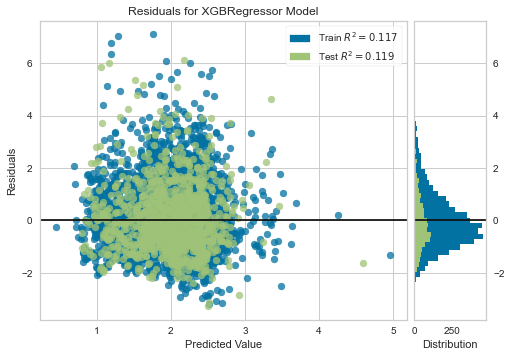

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [78]:
le = preprocessing.LabelEncoder()
combined['sector_int'] = le.fit_transform(combined['sector'].astype(str))
combined['industry_int'] = le.fit_transform(combined['industry'].astype(str))
data = combined[combined['activity']>= 0.01 ].copy()

#try log target, since outliers -- has huge impact on performance
data['closemarket_pct30_log'] = np.log(data['closemarket_pct30'])

vars = ['activity_15','sentiment_15','ShortRatio_15','TotalVolume_15',
        'activity_5','sentiment_5','ShortRatio_5','TotalVolume_5',
        'activity','sentiment','ShortRatio','TotalVolume',
        'evebitda','ps','pb','pe','marketcap','sector_int','industry_int']

target = 'closemarket_pct30_log'

X_train, X_test, y_train, y_test = model_setup(
        data,
     vars, 
    target)

visualizer = ResidualsPlot(XGBRegressor(n_estimators=1000
                   ,booster='gblinear'
                  ))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

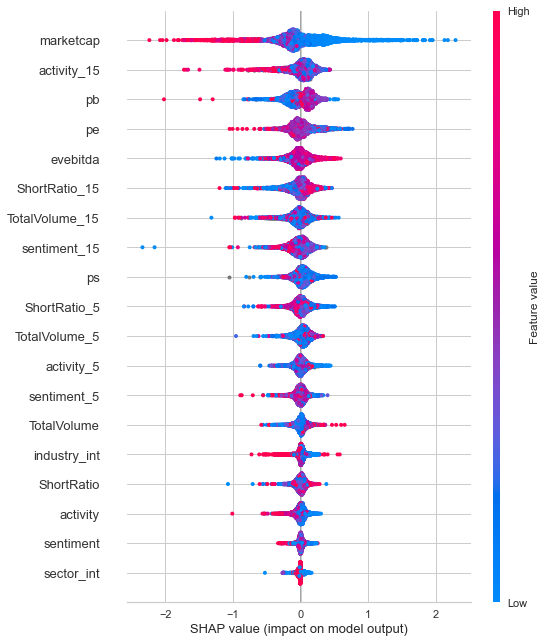

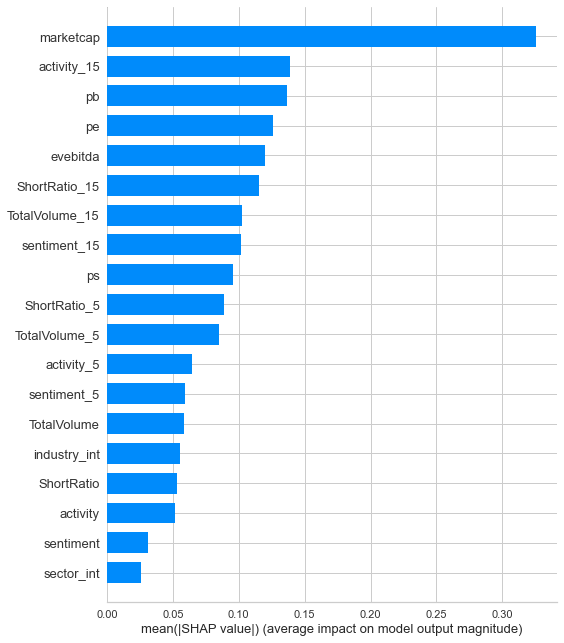

In [80]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_train)

#CLASSIC SHAP SUMMARY PLOT
shap.summary_plot(shap_values, X_train)

#SHAP FEATURE IMPORTANCE
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Classifier

as i increase the rolling timespan, accuracy goes up for 180 prediction -- is this leakage? Model actually seems good (suspicious) - 86% acc, .94 rocauc

    - pos180 vs 30(act,sent,shortratio,totalvolume)
    - when activtiy > 0.01

i bet totalvolume is having some leakage -- not standardized (dropping it does remove about 9 pts of acc)

    - see below about signaling ticker (anyone can predict the ticker from this info, not the task)

does this hold up when I use entire dataset??

When i add evebitda, acc goes wayyy up - has to be leakage (YES - bc evebitda would signal which ticker it is -- need evebitda change maybe)

    - I think the other variables may be signaling the ticker as well

In [12]:
le = preprocessing.LabelEncoder()
combined['sector_int'] = le.fit_transform(combined['sector'].astype(str))
combined['industry_int'] = le.fit_transform(combined['industry'].astype(str))
data = combined[combined['activity']>= 0.01 ].copy()

vars = ['activity_15','sentiment_15','ShortRatio_15','TotalVolume_15',
        'activity_5','sentiment_5','ShortRatio_5','TotalVolume_5',
        'activity','sentiment','ShortRatio','TotalVolume',
        'evebitda','ps','pb','pe','marketcap','sector_int','industry_int']

target = 'closemarket_pos30'

X_train, X_test, y_train, y_test = model_setup(
        data,
     vars, 
    target)

In [13]:
%%time
#fit and predict 
bst = XGBClassifier(n_estimators=1000,eval_metric='error',use_label_encoder=False
                  )
bst.fit(X_train,y_train)
predictions = bst.predict(X_test)
probpredictions = bst.predict_proba(X_test)[:,1]

Wall time: 5.59 s


In [14]:
y_test.mean()

0.4977300866694181

In [15]:
accuracy_score(y_test,predictions)

0.859678085018572

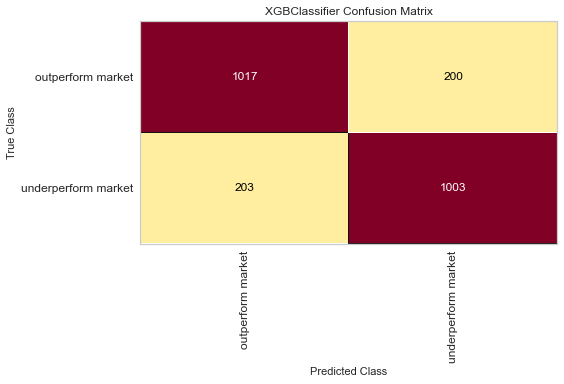

<AxesSubplot:title={'center':'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [16]:
#show classification results in graphs
visualizer = ConfusionMatrix(XGBClassifier(n_estimators=100,eval_metric='error',use_label_encoder=False
                  ),
                            classes=['outperform market','underperform market'])

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

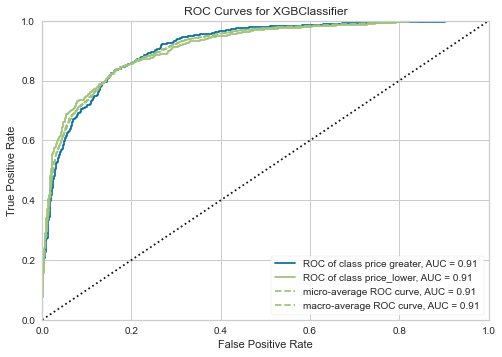

<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [17]:
visualizer = ROCAUC(XGBClassifier(n_estimators=100,eval_metric='error',use_label_encoder=False
                                 ),
                   classes=['price greater','price_lower'])

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

In [37]:
X_test['preds'] = predictions
X_test['proba_preds'] = probpredictions
X_test['true'] = y_test

In [38]:
#shap values or some contribution goal
# what's a good way to look at proba preds vs true class (to see if my probabilities are legit)
X_test['ticker'] = combined['ticker']
X_test['date'] = combined['date']
X_test['market chng'] = combined['closemarket_pct180']
X_test['actual chng'] = combined['closeadj_pct180']
X_test['proba_bins'] =pd.cut(X_test['proba_preds'],10,right=False,labels=False)
X_test['correct'] = X_test['preds'] ==X_test['true']

In [39]:
# actual mean value vs each predicted probability bin - see a linear trend
px.bar(X_test.groupby('proba_bins').mean(),
       x=X_test.groupby('proba_bins').mean().index,
       color='correct',
       y='true')

In [40]:
X_test[X_test['ticker'] =='MSFT']['preds'].mean()

0.6323529411764706

In [41]:
X_test[X_test['ticker'] =='MSFT']['true'].mean()

0.625

In [43]:
# predict on newest date
newdata = combined[(combined['date'] == '2023-01-11' ) & (combined['activity']>.01)][vars]
newpreds = bst.predict(newdata)
newproba = bst.predict_proba(newdata)[:,1]

newdata['preds'] = newpreds
newdata['proba_prebs'] = newproba
newdata['ticker'] = combined['ticker']
newdata['date'] = combined['date']
newdata['activity'] = combined['activity']

newdata

activity_15  sentiment_15  ShortRatio_15   TotalVolume_15  \
5865342     0.039887     -1.200000       0.476284  37438773.333333   
5865153     0.017020     -5.000000       0.433839  27435467.400000   
5865114     0.026013     -0.666667       0.391286  32862514.866667   
5862889     0.012980     -5.266667       0.351198  10306902.400000   
5862698     0.026167     -4.000000       0.456230  22398266.733333   
5861626     0.145567     -2.733333       0.490453 111386632.200000   

         activity_5  sentiment_5  ShortRatio_5    TotalVolume_5  evebitda  \
5865342    0.036540     1.000000      0.485806  34835450.800000 16.700000   
5865153    0.017180    -1.800000      0.475773  30147976.000000 19.200000   
5865114    0.027440     1.800000      0.450571  36424699.800000 21.000000   
5862889    0.014920    -1.800000      0.380229  12296863.400000 17.000000   
5862698    0.027180    -1.000000      0.511752  23223276.800000 54.100000   
5861626    0.135180    -2.600000      0.527082 112975086.600000 23.100000   

               ps        pb        pe      marketcap  sector_int  \
5865342  5.400000 41.900000 21.300000 2123574.700000           9   
5865153  4.900000  2.000000 49.000000  111349.300000           9   
5865114  1.900000  7.100000 85.700000  970075.300000           9   
5862889  8.700000 10.100000 25.200000 1757541.100000           9   
5862698 13.800000 18.400000 66.100000  393624.600000           9   
5861626  5.200000  9.800000 34.800000  389098.300000           2   

         industry_int  preds  proba_prebs ticker        date  activity  
5865342            31      1     0.922572   AAPL  2023-01-11  0.035600  
5865153           124      0     0.034542    AMD  2023-01-11  0.015800  
5865114            75      0     0.072068   AMZN  2023-01-11  0.038500  
5862889           128      1     0.954356   MSFT  2023-01-11  0.013000  
5862698           124      0     0.223676   NVDA  2023-01-11  0.024700  
5861626            10      0     0.006514   TSLA  2023-01-11  0.140700

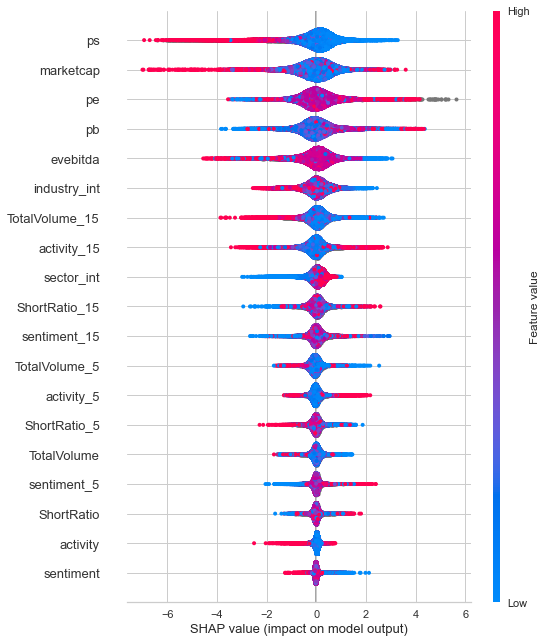

In [91]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)

#CLASSIC SHAP SUMMARY PLOT
shap.summary_plot(shap_values, X_train)

#SHAP FEATURE IMPORTANCE
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [81]:
# # INTERACTION PLOTS
# for name in X_train.columns:
#     shap.dependence_plot(name,shap_values,X_train)

# Multi-Classification

Idea is to bucket returns into classes